# Data loading

In [1]:
#  to present any diagrams inline with the rest of the notebook as opposed to in new browser window
%matplotlib inline 

# importing necessary modules
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

#scikit imports around different regression components
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, classification_report, mean_squared_error
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict, cross_val_score, train_test_split, StratifiedKFold,RandomizedSearchCV

# regularized linear regression
from sklearn.linear_model import Ridge, RidgeCV

# ensemble imports
from sklearn.ensemble import RandomForestRegressor

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# initializing necessry constants
path_to_csv = "data/abalone.csv"
default_figure_out_path = 'figs/'
boxplot_fig_path = 'boxplots/'
decision_tree_fig_path = 'decision_tree'
default_figure_ext = '.png'
columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight','viscera_weight', 'shell_weight','rings']

In [3]:
df = pd.read_csv(path_to_csv, names=columns, header=None)

After loading of a dataset to verify that it was loaded correctly the dataframe object can be queried. 
The first thing to check is the size of the dataset, e.g. number of records and columns. Checking number of rows will elp determine if dataset is large enough to draw any conclusions from.

Additonally, various statistics around minimum, maximum, mean and others can be checked. It also would verify that the dataset was loaded correctly

In [4]:
orig_shape = df.shape
df.shape

(4177, 9)

In [5]:
df.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4176.000000,4177.000000
mean,0.523992,0.407675,0.139516,0.828742,0.359367,0.180574,0.238831
std,0.120093,0.100082,0.041827,0.490389,0.221963,0.109620,0.139203
min,0.075000,-0.430000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093375,0.130000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.170750,0.234000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.252625,0.329000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


From the table above it can straight away be observed that some values in the dataset will need to be cleaned - no measurement of a live abalone speciment should be negative or equal to 0.

# Data cleaning
## Checking for empty nad invalid records
The very first thing that needs to be performed on any dataset, before any analysis should be performed is cleaning the data. The rationale behind it is that missing records can and will skew any computations done on the dataset.
The very first check is to make sure tha all data imported is numeric, with exception of `sex` column

In [6]:
df.dtypes

sex                object
length            float64
diameter          float64
height            float64
whole_weight      float64
shucked_weight    float64
viscera_weight    float64
shell_weight      float64
rings              object
dtype: object

It can be observed that unexpetedly `rings` column is represented by an object type, which would only occur if some values for that column are not numeric, but instead a `string` or `null`.

In [7]:
# converting rings to numbers. Any text will turn into NaN. `coerce` option is used to suppress any conversion errors
df['rings'] = pd.to_numeric(df['rings'], errors='coerce')
df.dtypes

sex                object
length            float64
diameter          float64
height            float64
whole_weight      float64
shucked_weight    float64
viscera_weight    float64
shell_weight      float64
rings             float64
dtype: object

In [8]:
# checking that shape of the dataset didn't change as part of the conversion operation
def check_row_count(row_count_to_be_checked):
    if orig_shape[0] == row_count_to_be_checked:
        print('Row count did not change')
    else:
        print('Row count changed')

In [9]:
check_row_count(df.shape[0])

Row count did not change


In [10]:
nan_error = df.isnull().any(axis=1)
df[nan_error]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
878,F,0.635,0.485,0.165,1.2945,0.6680,NaN,0.2715,9.0
1888,F,0.565,0.445,0.125,0.8305,0.3135,0.1785,0.2300,NaN
3093,NaN,0.520,0.430,0.150,0.7280,0.3020,0.1575,0.2350,11.0
3466,M,0.640,0.500,0.170,1.4545,0.6420,0.3575,0.3540,NaN


From the data above we can see that some records are missing data:
 - Row 878 is missing `viscera weight` property
 - Row 1888 is missing `rings` value
 - Row 3093 doesn't have value for `sex` specified

## Checking dataset for errorenous data
Before re remove any data we shoul analyze if there are any errors in the dataset. It should e done before removal of any data as if the number or errors in data is significant in may become necessary to substitute wrong data and at the same time it may be possible to fill the data gaps as well.
### Values below or equal to 0
For abalone, as a living organism, it doesn't make sense for any of its attributes to be below or equal to zero.

In [11]:
below_or_zero=df[df <= 0.0 ].count()
below_or_zero

sex               4176
length               0
diameter             1
height               2
whole_weight         0
shucked_weight       0
viscera_weight       0
shell_weight         0
rings                0
dtype: int64

We're not concerned with `sex` column being reported as it's not a numeric data. For the rings data we need to check it with `integer` type applied instead of a floating point one.

From the description and computation we see that there are a min of 0 for height and a negative value for diameter which in case of a living organism like abalone isn't valid. We need to track down which row exactly contain error data and remove them.

In [12]:
error_diameter=df['diameter'] <= 0.0
error_height = df['height'] <= 0.0
df[error_diameter]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
2758,M,0.535,-0.43,0.155,0.7845,0.3285,0.169,0.245,10.0


In [13]:
df[error_height]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8.0
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6.0


## Analyzing data for domain errors
Endemic to abalone itself it is invalid for any specimen to have:
 - higher weight when shucked (stripped of its shell) than whole weight
 - higher viscera weight than whole weight
 - higher shell weight than whole weight

We can do 2 things to find the errors:
 - computation method
 - scatter matrix dedicated to specific parameters listed above

While it is possible to identify errors using visual method by narrowing down the graph field to precise location of the errorneous data it is much faster to compute it.

In [14]:
shucked_error =df['shucked_weight'] > df['whole_weight']
df[shucked_error]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
1216,I,0.310,0.225,0.070,0.1055,0.4350,0.0150,0.0400,5.0
2627,I,0.275,0.205,0.070,0.1055,0.4950,0.0190,0.0315,5.0
2641,I,0.475,0.365,0.100,0.1315,0.2025,0.0875,0.1230,7.0
3086,I,0.355,0.270,0.075,0.2040,0.3045,0.0460,0.0595,7.0


In [15]:
df[df['viscera_weight'] > df['whole_weight']]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


In [16]:
shell_error = df['shell_weight'] > df['whole_weight']
df[shell_error]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6.0


## Summary of errorenous data
We have 4 rows with non-numerical values:
 - 878
 - 1888
 - 3093
 - 3466
 
7 rows with data that cannot be correct for domain reasons:
 - 4 where shucked weight is higher than whole weight
   - 1216
   - 2627
   - 2641
   - 3086
 - 1 row with negative value for diameter
   - 2758
 - 2 rows with 0 value for height
   - 1257
   - 3996

Row 3996 has been flagged by 2 checks as one containing impossible values: height and shell weight higher than whole weight, however, is only contributes towards row-error count once.
 
In summary we have 11 rows that either have to have some of the values substituted or removed.

From checking the tail of the dataset in previous section we know that the dataset contains 4176 rows. 

As such 10 rows with missing data comprises less than 0.26% of the dataset and removing such a small amount or errorenous data should not affect our analysis significantly. 
Had the number been more significant the missing data would have had to been substituted.

# Removing erroneous data

In [17]:
# deleting shucked weight > whole weight
df.drop(df.index[(shucked_error) | (error_diameter) | (error_height) | (nan_error)], inplace=True)

#verifying shucked > whole that records were dropped
df[df['shucked_weight'] > df['whole_weight']]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


In [18]:
# verifying NaN errors were deleted
df[df.isnull().any(axis=1)]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


In [19]:
#verifying diameter < 0 records were dropped
df[df['diameter'] <= 0.0]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


In [20]:
# verifying height <= 0 was dropped
df[df['height'] <= 0.0]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


# Indentifying outliers
## Box Plots

In [49]:
def set_16x16_figure():
    sb.set(rc={'figure.figsize':(16,16)})
def set_11x8_figure():
    sb.set(rc={'figure.figsize':(11,8)})
def set_7x5_figure():
    sb.set(rc={'figure.figsize':(7,5)})
def set_graph_size(size_enumerator):
    if size_enumerator == 's':
        set_7x5_figure()
    elif size_enumerator == 'm':
        set_11x8_figure()
    elif size_enumerator == 'l':
        set_16x16_figure()
    elif size_enumerator == 'mini':
        sb.set(rc={'figure.figsize':(6,4)})

def get_boxplot_path():
    return default_figure_out_path + boxplot_fig_path

def save_boxplot(graph_title):
    plt.savefig(get_boxplot_path()+graph_title+default_figure_ext, bbox_inches='tight')

def save_graph(graph_title):
    plt.savefig(default_figure_out_path + graph_title + default_figure_ext, bbox_inches='tight')
    
def save_tree_graph(graph_title, isErrorDist=False):
    fig_path = default_figure_out_path + decision_tree_fig_path + '/'
    
    if isErrorDist is True:
       fig_path = default_figure_out_path + decision_tree_fig_path + '_error_dist/'
    
    plt.savefig(fig_path+graph_title+default_figure_ext, bbox_inches='tight')

In [22]:
def calc_quartiles(column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lw = q1 - 1.5 * iqr
    uw = q3 + 1.5 * iqr
    return q1, q3, iqr, lw, uw
def format_dec(dec):
    return format(dec, '2.4')

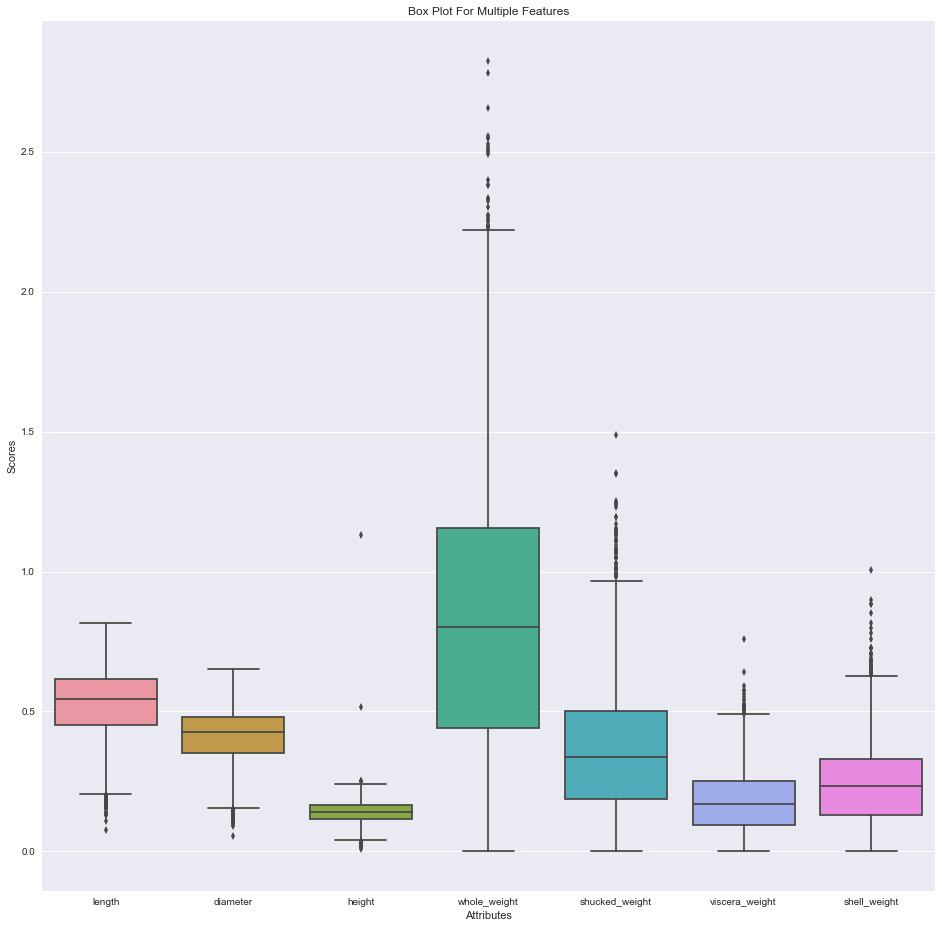

In [23]:
set_graph_size('l')
df_ringless=df.drop('rings',  axis='columns')
set_graph_size('l')
ax=sb.boxplot(data=df_ringless)
ax.set(xlabel='Attributes', ylabel='Scores', title="Box Plot For Multiple Features")
save_boxplot('boxplot_all_features_but_rings')

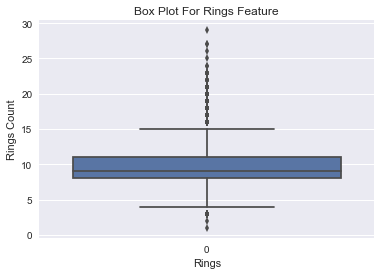

In [24]:
set_graph_size('mini')
ax=sb.boxplot(data=df['rings'])
ax.set(xlabel='Rings', ylabel='Rings Count', title="Box Plot For Rings Feature")
save_boxplot('boxplot_rings')

From the feature boxplots above it can be observed that quite a number of outlier values are present in the dataset. Before a decision can be made how to address these values a finla count of outlier observations should be computed. 

Alternatively, one could make a decision early and chose a regression method that is not so affected by the presence of outliers, such as decision tree regression, as opposed to linear regression which is highly susceptible.

In [25]:
q1, q3, iqr, lw, uw = calc_quartiles('rings')
outliers = (df['rings'] < lw) | (df['rings'] > uw)
non_outliers_count = df['rings'][~outliers].count()
outlier_count = len(df['rings'])-df['rings'][~outliers].count()
print('Ring outlier values consist of {0}% of the entire dataset'.format(format_dec((outlier_count/len(df['rings']))*100)))

Ring outlier values consist of 6.673% of the entire dataset


Given that outliers for the `rings` column alone consisted of over 6.5% of the complete dataset it was decided against proceeding with any linear regression modelling due to its susceptability to outlier values - either removing or imputing te values would have had an effect on the overall prediction capability.

Instead efforts were focused around the decission tree regression models.

# Decision Tree Regression
## Dummy regressor

Before proceeding with any modelling `sex` column, which has been established to contain text values, needs to be encoded.

In [26]:
# got to encode sex column for base dataset using hot-one method as linear regression model only works with quantitative data
encoded_sex = pd.get_dummies(df['sex'])
df = pd.concat([df, encoded_sex], axis='columns')
df = df.drop('sex', axis='columns')

df.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,F,I,M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15.0,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7.0,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9.0,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10.0,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7.0,0,1,0


In [27]:
def print_model_stats(y_pred, y):
    errors = abs(y_pred - y)
    print('Mean Absolute Error:', round(np.mean(errors), 5), 'degrees.')
    mape = 100 * (errors / y)
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 5), '%.')
    print('Mean absolute error: \t\t%f' % mean_absolute_error(y, y_pred))
    print('Standard deviation of the error: %f' % (y - y_pred).std())
    print('Mean squared error\t\t', mean_squared_error(y, y_pred))
    print('RMSE\t\t\t\t', sqrt(mean_squared_error(y, y_pred)))

## Baseline

Mean Absolute Error: 2.08545 degrees.
Accuracy: 79.54881 %.
Mean absolute error: 		2.085454
Standard deviation of the error: 3.038787
Mean squared error		 9.233797407585215
RMSE				 3.0387164078908735
Error mean: -0.04224675948151704
Error median: 0.0


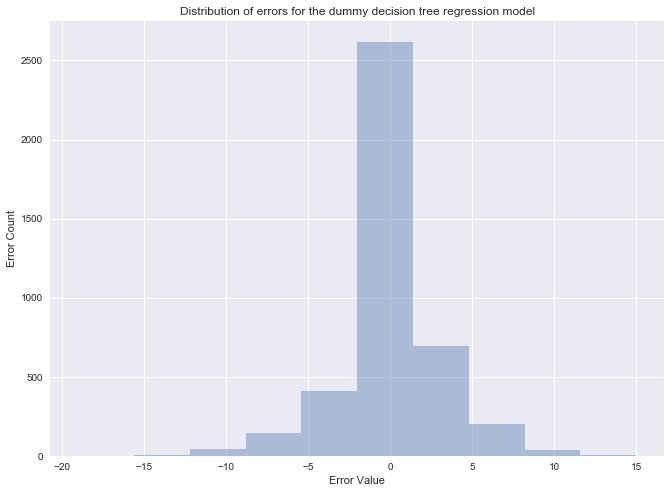

In [28]:
X = df.drop('rings', axis='columns')  # X = features
y = df['rings']                       # y = prediction target
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)  # K = 5
outer_cv = KFold(n_splits=10, shuffle=True, random_state=0)  # 5-fold cross validation

regression_tree = DecisionTreeRegressor()
regression_tree.fit(X,y)
y_pred = cross_val_predict(regression_tree, X, y, cv=outer_cv)
cv_scores = cross_val_score(regression_tree, X, y, cv=5) 

difference=y - y_pred
set_graph_size('m')
ax = sb.distplot(difference, bins=10, kde=False)
ax.set(
    title='Distribution of errors for the dummy decision tree regression model',
    xlabel='Error Value',
    ylabel='Error Count'
);


save_tree_graph('decison_tree_dummy', True)

print_model_stats(y_pred, y)
print('Error mean:', np.mean(difference))
print('Error median:', np.median(difference))

## Searching for the best parameters

In [29]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import make_scorer
# cv=KFold(n_splits=5, shuffle=True, random_state=0)  # K = 5
# regression_tree_in_grid = DecisionTreeRegressor()
# params = {'max_depth': range(1,20), # for mae criterion max depth range has been decresed to (1, 10) as otherwise the search would have taken very long time to complete
#           'min_samples_leaf': range(1,21),
#           'min_samples_split':range(2,11),
#           'min_weight_fraction_leaf':(0,0.5),
#           'criterion': ['mse', 'friedman_mse'] 
#           # commented out as MAE grid search on its own took about 1 hour to complete. Compounding it with the other parameters 
#           # would lead to significant amount of time spend on just grid search.
#           # Could have implemented RandomSearch, however, wanted the completeness, as well as less randomization of results.
#           #'criterion': ['mse', 'mae','friedman_mse'] 
#          }
# scoring_function = make_scorer(r2_score)
# grid = GridSearchCV(regression_tree_in_grid, param_grid=params, scoring=scoring_function, cv=cv, verbose=2, n_jobs=-1)
# grid = grid.fit(X, y)
# grid.best_estimator_

In [30]:
# above cell was at attempt at hyper parameter optimization brute force, however, while finding rather consistent results, it failed to 
# accommodate 'mae' criterion due to the number of combinations to be calculated for each iteration. Instead decided to implement
# randomized grid search which may not consistently allow for producing the exact same prediction accuracy. However, since the
# difference between the model fitting runs were in the 0.001 range it was deemed acceptable.
random_dt_grid = {'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(start = 1, stop = 300, num = 10)],
               'min_samples_split':  [int(x) for x in np.linspace(start = 2, stop = 300, num = 10)],
               'min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 300, num = 10)],
               'min_weight_fraction_leaf':(0,0.5),'criterion': ['mse', 'mae', 'friedman_mse']}


dtr = DecisionTreeRegressor()
dtr_random = RandomizedSearchCV(estimator = dtr, param_distributions = random_dt_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
dtr_random.fit(X, y)

print('Best params', dtr_random.best_params_)

Best params {'min_weight_fraction_leaf': 0, 'min_samples_split': 2, 'min_samples_leaf': 101, 'max_features': 'auto', 'max_depth': 67, 'criterion': 'mse'}


In [31]:
# The following "report" method has been reused, with minute modifications, from sci-kit learn documentation 
# and examples section available in full at: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html

# Utility function to report best scores
def report(results, n_top=1):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            return results['params'][candidate]

dtr_random.fit(X,y)
best_params = report(dtr_random.cv_results_)
print(best_params)

Mean validation score: 0.473 (std: 0.011)
Parameters: {'min_weight_fraction_leaf': 0, 'min_samples_split': 2, 'min_samples_leaf': 101, 'max_features': 'auto', 'max_depth': 67, 'criterion': 'mse'}

{'min_weight_fraction_leaf': 0, 'min_samples_split': 2, 'min_samples_leaf': 101, 'max_features': 'auto', 'max_depth': 67, 'criterion': 'mse'}


Mean Absolute Error: 1.62877 degrees.
Accuracy: 83.84259 %.
Mean absolute error: 		1.628770
Standard deviation of the error: 2.299605
Mean squared error		 5.286958872237341
RMSE				 2.2993387902258644
RSS score:			 0.5292596309656745

Cross validation scores
 	Mean:			 0.3757977678384859 
	Standard deviation:	 0.12666231348882265

Error mean: -0.006845667284783718
Error median: -0.3423423423423415


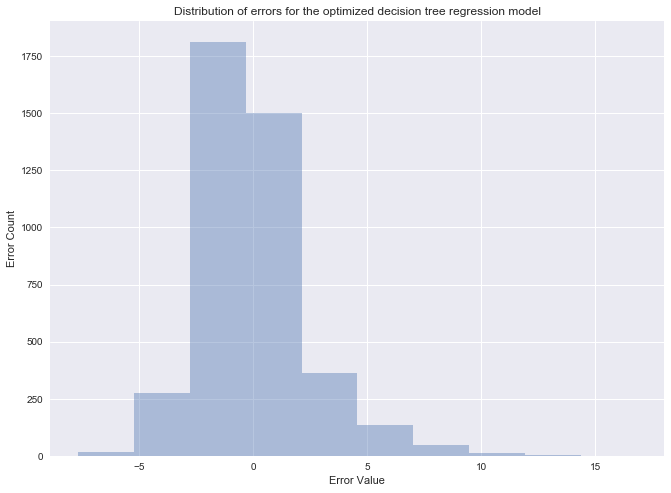

In [32]:
X = df.drop('rings', axis='columns')  # X = features
y = df['rings'] 
regression_tree = dtr_random.best_estimator_  #reusing best tree estimator found by random search


regression_tree.fit(X,y)

y_pred = cross_val_predict(regression_tree, X, y, cv=outer_cv)
cv_scores = cross_val_score(regression_tree, X, y, cv=5) 

difference3=y - y_pred

set_graph_size('m')
ax = sb.distplot(difference3, bins=10, kde=False)
ax.set(
    title='Distribution of errors for the optimized decision tree regression model',
    xlabel='Error Value',
    ylabel='Error Count'
);


save_tree_graph('decison_tree_optimized', True)


print_model_stats(y_pred, y)
tree_rss_score_volume = regression_tree.score(X,y)
print('RSS score:\t\t\t', tree_rss_score_volume)
print("\nCross validation scores\n \tMean:\t\t\t",np.mean(cv_scores),"\n\tStandard deviation:\t", np.std(cv_scores))
print('\nError mean:', np.mean(difference3))
print('Error median:', np.median(difference3))

In [33]:
tree_rss_score_volume = regression_tree.score(X,y)
print('RSS score:\t\t\t', tree_rss_score_volume)
print("\nCross validation scores\n \tMean:\t\t\t",np.mean(cv_scores),"\n\tStandard deviation:\t", np.std(cv_scores))

RSS score:			 0.5292596309656745

Cross validation scores
 	Mean:			 0.3757977678384859 
	Standard deviation:	 0.12666231348882265


## Random Forest

Mean Absolute Error: 1.62115 degrees.
Accuracy: 83.87362 %.
Mean absolute error: 		1.621147
Standard deviation of the error: 2.280599
Mean squared error		 5.203223715794527
RMSE				 2.281057587128069
RSS score:			 0.9137176837966485

Cross validation scores
 	Mean:			 0.39435240656805876 
	Standard deviation:	 0.10483762307850573

Error mean: -0.05777724435909777
Error median: -0.2999999999999998


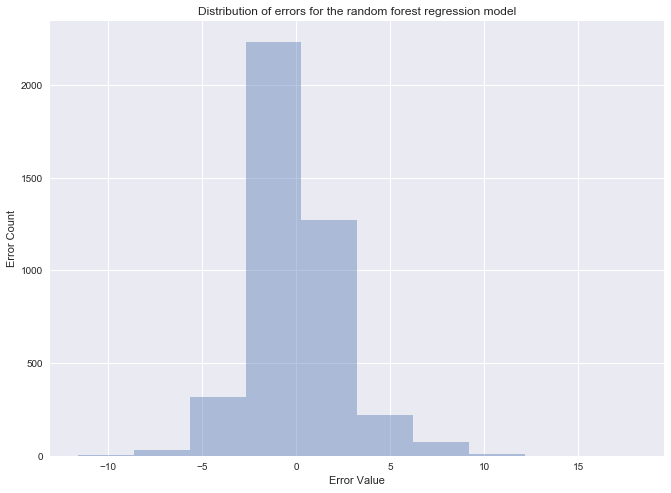

In [35]:
random_forest = RandomForestRegressor(n_estimators = 10, random_state = 42)
random_forest.fit(X, y)


y_pred = cross_val_predict(random_forest, X, y, cv=outer_cv)
cv_scores = cross_val_score(random_forest, X, y, cv=5) 

set_graph_size('m')
difference_rand_forest=y - y_pred
ax = sb.distplot(difference_rand_forest, bins=10, kde=False)
ax.set(
    title='Distribution of errors for the random forest regression model',
    xlabel='Error Value',
    ylabel='Error Count'
);


save_tree_graph('random_forest_unoptimized', True)

print_model_stats(y_pred, y)
forest_rss_score_volume = random_forest.score(X,y)
print('RSS score:\t\t\t', forest_rss_score_volume)
print("\nCross validation scores\n \tMean:\t\t\t",np.mean(cv_scores),"\n\tStandard deviation:\t", np.std(cv_scores))
print('\nError mean:', np.mean(difference_rand_forest))
print('Error median:', np.median(difference_rand_forest))

In [40]:
# random_forest_grid = {'max_features': ['auto', 'sqrt'],
#                'max_depth': [int(x) for x in np.linspace(start = 1, stop = 300, num = 10)],
#                'min_samples_split':  [int(x) for x in np.linspace(start = 2, stop = 300, num = 10)],
#                'min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 300, num = 10)],
#                'min_weight_fraction_leaf':(0,0.5),'criterion': ['mse', 'mae', 'friedman_mse']}


# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_forest_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
# dtr_random.fit(X, y)

# rf_random('Best params', rf_random.best_params_)

random_forest_grid = {'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(start = 1, stop = 300, num = 10)],
               'min_samples_split':  [int(x) for x in np.linspace(start = 2, stop = 300, num = 10)],
               'min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 300, num = 10)],
               'min_weight_fraction_leaf':(0,0.5),'criterion': ['mse', 'mae', 'friedman_mse']}


rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_forest_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
rf_random.fit(X, y)

print('Best params', rf_random.best_params_)

Best params {'min_weight_fraction_leaf': 0, 'min_samples_split': 2, 'min_samples_leaf': 35, 'max_features': 'auto', 'max_depth': 200, 'criterion': 'mae'}


Mean Absolute Error: 1.51047 degrees.
Accuracy: 85.7197 %.
Mean absolute error: 		1.510466
Standard deviation of the error: 2.213303
Mean squared error		 5.084859577532406
RMSE				 2.254963320662313
RSS score:			 0.5302565477667152

Cross validation scores
 	Mean:			 0.4501011983736694 
	Standard deviation:	 0.09197026053673657

Error mean: 0.4328132501200216
Error median: 0.0


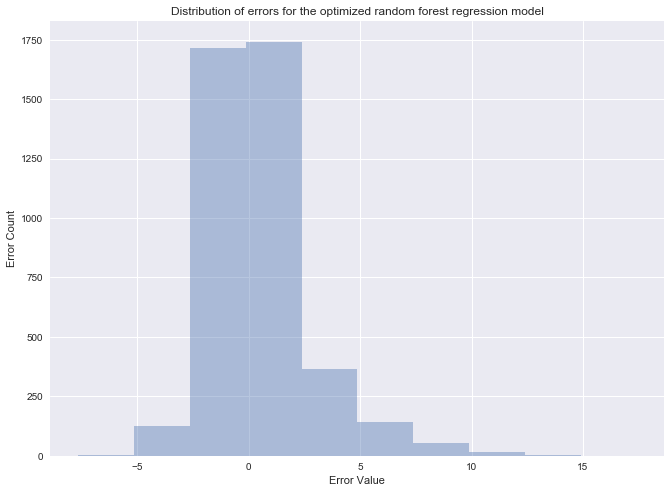

In [41]:
X = df.drop('rings', axis='columns')  # X = features
y = df['rings'] 
random_forest = rf_random.best_estimator_  #reusing best tree estimator found by random search


random_forest.fit(X,y)

y_pred = cross_val_predict(random_forest, X, y, cv=outer_cv)
cv_scores = cross_val_score(random_forest, X, y, cv=5) 

random_forest_difference=y - y_pred

set_graph_size('m')
ax = sb.distplot(random_forest_difference, bins=10, kde=False)
ax.set(
    title='Distribution of errors for the optimized random forest regression model',
    xlabel='Error Value',
    ylabel='Error Count'
);


save_tree_graph('random_forest_optimized', True)


print_model_stats(y_pred, y)
forest_rss_score_volume = random_forest.score(X,y)
print('RSS score:\t\t\t', forest_rss_score_volume)
print("\nCross validation scores\n \tMean:\t\t\t",np.mean(cv_scores),"\n\tStandard deviation:\t", np.std(cv_scores))
print('\nError mean:', np.mean(random_forest_difference))
print('Error median:', np.median(random_forest_difference))

## Regularized Regression - Ridge

In [45]:
# checking if least squares if better suited, where RSS is defined as ridge regression with alpha = 0
X = df.drop(['rings'], axis='columns')  # X = features
y = df['rings']                       # y = prediction target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

ridge4 = Ridge(alpha = 0, normalize = True)
ridge4.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred4 = ridge4.predict(X_test)           # Use this model to predict the test data
print('Coefficient Values: \n',pd.Series(ridge4.coef_, index = X.columns)) # Print coefficients

# print('\nMSE:',mean_squared_error(y_test, pred4)) # Calculate the test MSE
# print('\nMAE:', mean_absolute_error(y_test, pred4))

print('\nModel Statistics:')
print_model_stats(pred4, y_test)
print('Ridge score:', ridge4.score(X_test, y_test), ridge4.coef_)
mse_least_squares=mean_squared_error(y_test, pred4)
mae_least_squares=mean_absolute_error(y_test, pred4)
ridge_least_squares=ridge4.score(X_test, y_test), ridge4.coef_

Coefficient Values: 
 length             1.235871
diameter          10.106245
height             7.954302
whole_weight       9.551859
shucked_weight   -21.258392
viscera_weight    -9.181109
shell_weight       8.267466
F                 15.386890
I                 14.688967
M                 15.505490
dtype: float64

Model Statistics:
Mean Absolute Error: 1.59176 degrees.
Accuracy: 84.068 %.
Mean absolute error: 		1.591763
Standard deviation of the error: 2.262561
Mean squared error		 5.118553565256619
RMSE				 2.262422057277691
Ridge score: 0.508428050425842 [  1.23587114  10.10624528   7.95430216   9.55185892 -21.25839183
  -9.1811089    8.26746635  15.38689012  14.6889667   15.50549044]


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.9741027613659274e-17 / 1.1102230246251565e-16
  RuntimeWarning)


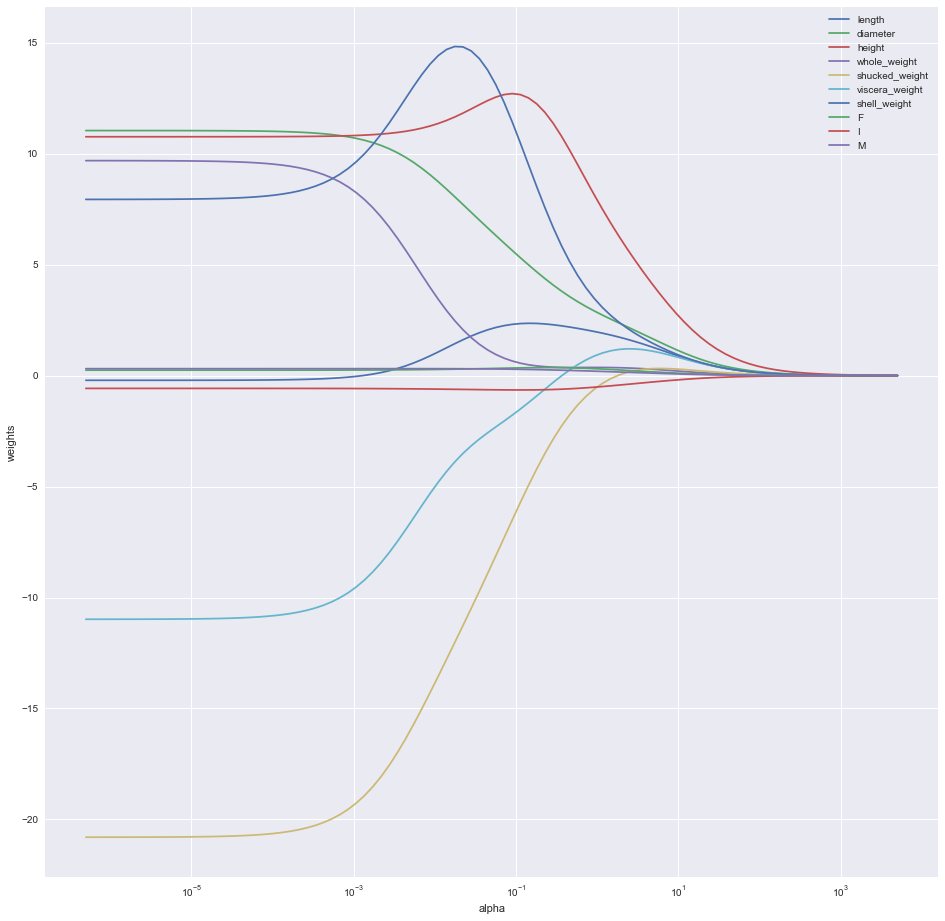

In [56]:
alphas = 10**np.linspace(4,-6,100)*0.5
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

set_graph_size('l')
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.legend(X)
save_tree_graph('ridge_coef_change_by_alpha', False)

In [47]:
# instead of arbitrarily choosing alpha from the graph above, pefrorm CV to check which value is best
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.00019267642968552598

In [48]:
# ridge regression using the alpha calculated by cross validated ridge regression
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
ridge2 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
# print('\nMSE:',mean_squared_error(y_test, pred2))          # Calculate the test MSE
# print('\nMAE:', mean_absolute_error(y_test, pred2))
print_model_stats(pred2, y_test)
print('Ridge score:', ridge.score(X_test, y_test), ridge.coef_)
mse_alpha_005=mean_squared_error(y_test, pred2)
mae_alpha_005=mean_absolute_error(y_test, pred2)
ridge_alpha_005=ridge.score(X_test, y_test), ridge.coef_

length             1.128776
diameter           9.784179
height             9.886104
whole_weight       9.785833
shucked_weight   -21.139601
viscera_weight   -10.317330
shell_weight       7.558336
F                  0.241269
I                 -0.551122
M                  0.291682
dtype: float64
Mean Absolute Error: 1.56496 degrees.
Accuracy: 84.40793 %.
Mean absolute error: 		1.564961
Standard deviation of the error: 2.195113
Mean squared error		 4.821239560539944
RMSE				 2.195732124039712
Ridge score: 0.5145318465473905 [ -0.21104542  11.04284906  10.76344202   9.6873144  -20.80009405
 -10.97891904   7.94008754   0.24596686  -0.57634358   0.31304007]


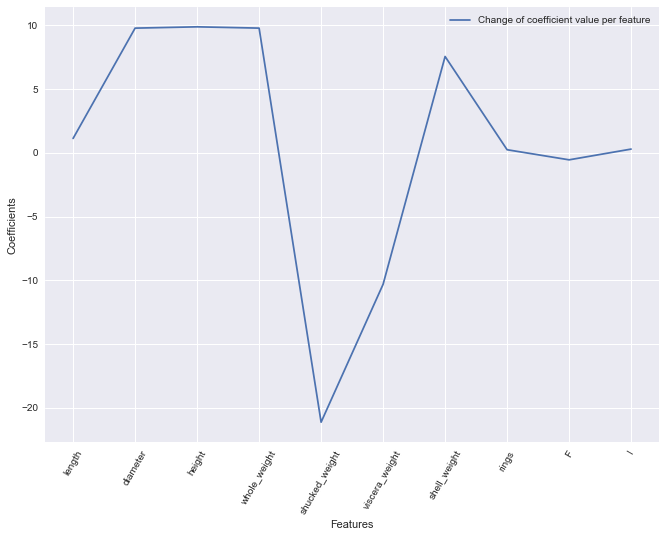

In [51]:
# plot a graph of the coefficients
set_graph_size('m')
_ = plt.plot(range(X.columns.shape[0]), ridge2.coef_)
_ = plt.xticks(range(X.columns.shape[0]), df, rotation=60)
_ = plt.ylabel('Coefficients')
_ = plt.xlabel('Features')
_ = plt.legend(['Change of coefficient value per feature'])
save_graph('ridge_coefficients_plot')

In [52]:
print('Is MSE for least squares smaller than MSE with alpha 0.005?', mse_least_squares < mse_alpha_005)
print('Difference between least squares MSE and alpha 0.005 MSE:', mse_least_squares-mse_alpha_005)
print('\nIs MAE for least squares smaller than MAE with alpha 0.005?', mae_least_squares < mae_alpha_005)
print('Difference between least squares MAE and alpha 0.005 MAE:', mae_least_squares-mae_alpha_005)
print('\nIs ridge score for RSS smaller than fitted ridge:', ridge_least_squares[0]<ridge_alpha_005[0])
print('Difference between RSS score and fitted ridge score:', ridge_least_squares[0]-ridge_alpha_005[0])

Is MSE for least squares smaller than MSE with alpha 0.005? False
Difference between least squares MSE and alpha 0.005 MSE: 0.29731400471667513

Is MAE for least squares smaller than MAE with alpha 0.005? False
Difference between least squares MAE and alpha 0.005 MAE: 0.02680167324010685

Is ridge score for RSS smaller than fitted ridge: True
Difference between RSS score and fitted ridge score: -0.006103796121548433


Using cross validated Ridge Regression function to identify the best alpha parameter for conducting ridge regression to obtain mean as well as from comparing mean squared error and mean absolute error results, while using MSE and MAE of least squares calculation as a baseline, we can deduce that ridge regression indeed improved our prediction score and that the parameters for the calculation have been tuned.

The best score to get out of a prediction, or regression, model is 0 as it would mean that the predicted and actual data matched up. The above graph we can observer that majority of the data is centered around 0, however at the same time significant portion of the dataset is significantly away from the 0 error value. 
Mean absolute error score is at almost 2 which means that the dummy model leaves room for improvement.